# BCN-M refactoring

The code generates the NP0 with all anions in the outer shell.
It returns the list of atoms with lowest coordination (these are the ones we want to remove from the anions).
I am getting the coordination of the cations they are linked to (11/09/23)

Think of goals to optimise the NP0 -> NP

Develop Monte Carlo method (select how many structures, generate the list of unique radom numbers, remove sites, append and check for SIC -> descriptor) order by dipole.

Extra: only MC among anions that are linked to non-undercoordinated atoms.

Let the user choose what is the undercoordinated atom.

### Workflow
- generate NP0
- find excess atoms
- find undercoordinated atoms
- find coordination cations
- singularisator 

### Parameters
- bulk structure
- NP size
- excess atom removal
    - undercoordinated first then MC
    - MC
- number of attempts
- number of returned structures

#### WIP
- reduce the NP to the oumost layers to reduce the cost of the stroichiometricization
- create the np0 with all dangling anions

#### Functions
- make_stoichiometric(): return a list of structures and other info
    - build_np0()
        - improved so it builds a np0 where all the surface atoms are the most abundant atom ✅ 
    - remove_undercoordinated_atoms()
    - get_coordination() ✅ 
    - is_stoichiometric()
    - get_surface_atoms() ✅ 
    - get_excess_atoms() ✅ 
        - check if the anion is in excess + stop and restart with larger NP
    - remove_excess_atoms()
        - by coordination
            - sort by coordination of the excess atom and coordination of the atom it is attached to
            - start by removing lower coordination, if more than one option is possible -> combinatory analysis
    - optimisation()
        - Think of criteria (goals) - QUBO?
        - sorted
        - Monte Carlo (np.random)
        - Heuristic
        - SA
        - Quantum (how)?
        - Symmetry analysis
        
    
#### User workflow
- call bcn_wulff_construction
- call the individual functions that bcn_wulff_construction calls
- jn
- running bcnm.py: define where to save the np

#### NP quality
- 

#### Remove excess atoms


#### Memory
- the original version runs by calling bcnm.py as a python program with an yaml input file
- it defines all the input defined options and then calls bcn_wulff_construction in bcnm/bcn_wulff, which calls all the other functions

### Refactoring
- Stop using ASE functions to generate the NP0 ✅ 
    - improve the size of the initial cluster ✅ 
- Use Nanoparticle format/pymatgen
- Save NP to xyz/cif with symmetry
- Include all the auxiliary functions
- Terminations?

### Limitations
- Get coordinations only returns one coordination value, which could be wrong for some systems

### Type of excess/surface atoms
- maa single coordinated
- maa higher coordination
- laa linked to a maa single coordinated atom

### Goals in removing atoms
- not leave severely undercoordinated atoms
    - adjacency matrix
    
### Debugging
- Rutile NP0 looks strange for certain formats

In [1]:
from bcnm.bcn_wulff_new import *

from pymatgen.analysis.wulff import WulffShape

# Import the necessary tools to generate surfaces
from pymatgen.core.surface import Lattice, SlabGenerator, Structure, generate_all_slabs

from pymatgen.io.ase import AseAtomsAdaptor
from pymatgen.io.cif import CifWriter

from ase.visualize import view

from pymatgen.core.structure import Structure,Lattice
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor

import numpy as np
import copy
import bisect

/Users/brunocamino/Desktop/Imperial/bcnm/NanoGenCat/bcnm/bcn_wulff_new.py:1133: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if check_stoich(atoms,coord) is 'stop':
/Users/brunocamino/Desktop/Imperial/bcnm/NanoGenCat/bcnm/bcn_wulff_new.py:1714: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if check_stoich_v2(symbol,atoms,debug) is 'stop':
/Users/brunocamino/Desktop/Imperial/bcnm/NanoGenCat/bcnm/bcn_wulff_new.py:1718: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if check_stoich_v2(symbol,atoms,debug) is 'stoichiometric':


In [2]:
def vview(structure):
    view(AseAtomsAdaptor().get_atoms(structure))

# This is it

# Rutile

In [3]:
from CRYSTALpytools.crystal_io import *
from CRYSTALpytools.convert import *
rutile_gui = Crystal_gui().read_gui('./data/rutile.gui')
rutile_pmg = cry_gui2pmg(rutile_gui)
rutile_pmg = SpacegroupAnalyzer(rutile_pmg).get_conventional_standard_structure()

In [123]:
view(AseAtomsAdaptor().get_atoms(rutile_pmg))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [6]:
lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])

surfaces = [[1, 1, 0],[0, 1, 1],[1, 0, 0],[0, 0, 1]]

energies = [0.673,1.186,0.961,1.362]

charges = {'Ti': 4, 'O': -2}  # Example charges dictionary

structure_init = copy.deepcopy(rutile_pmg)
structure = copy.deepcopy(rutile_pmg)
structure.add_oxidation_state_by_element(charges)

# Assign oxidation states to the structure
structure.add_oxidation_state_by_element(charges)

#nano = Nanoparticle(structure)
#nano = nano.make_stoichiometric(surfaces,energies,size=100)


#### Build NP0

In [397]:
def build_np0(structure_init,surfaces,energies,size,rounding='closest',center=None):
# This function returns the non stoichiometric np0 with size closest to the requested one

    from pymatgen.analysis.wulff import WulffShape
    from scipy.spatial import Delaunay, ConvexHull
    
    structure = copy.deepcopy(structure_init)
    # Most/less abundant atoms
        
    laa = get_less_abundant_atom(structure_init)
    maa = get_more_abundant_atom(structure_init)
    
    
    #Get max coordination
    structure_tmp = copy.deepcopy(structure_init)
    structure_tmp.make_supercell(np.identity(3)*2)
    max_coord = np.max(get_coordination(structure_tmp))
    
    wulffshape = WulffShape(structure.lattice, surfaces, energies)

    atom_density = structure.num_sites/structure.volume

    ###Add rounding
    
    if center is not None:
        structure_center = copy.deepcopy(structure_init)
        structure_center.translate_sites(np.arange(structure_init.num_sites),center,
                                     frac_coords=True,to_unit_cell= False)
    else:
        structure_center = copy.deepcopy(structure_init)
        
    if type(size) == int:
        new_volume = size/atom_density
        ratio = new_volume**(1/3)/wulffshape.volume**(1/3)

        if debug == True:
            shape = ConvexHull((wulffshape.wulff_convex.points/(wulffshape.volume**(1/3)))*(new_volume**(1/3)))        
            print('NP0 size = ',shape.volume*atom_density)

        shape = Delaunay(wulffshape.wulff_convex.points*(ratio))
        
        #loop to make sure to use the smallest supercell
        num_sites = 0
        for i in range(1,10):
            structure = copy.deepcopy(structure_center)
            # Generate the supercell      
            supercell_matrix = np.zeros((3,3)) ###Make this better
            expansion = np.ceil((np.max(shape.points,axis=0)-np.min(shape.points,axis=0))/np.array(structure.lattice.abc))+i
            np.fill_diagonal(supercell_matrix,expansion)
            structure.make_supercell(supercell_matrix)

            # Center around the center of mass
            center_of_mass = np.average(structure.cart_coords,axis=0)
            structure.translate_sites(np.arange(structure.num_sites),
                                      -center_of_mass,frac_coords=False,
                                      to_unit_cell= False)

            # Generate the list of atoms to be removed
            np0_sites = []
            sites_to_remove = []
            for i,coord in enumerate(structure.cart_coords):
                if (shape.find_simplex(coord) >= 0) == False:
                    sites_to_remove.append(i)
                if (shape.find_simplex(coord) >= 0) == True:
                    np0_sites.append(i)
            sites_to_remove = np.array(sites_to_remove)        
            np0_sites = np.array(np0_sites)

            #Surface less abundant atom:
            laa_surface_sites = np0_sites[np.where(np.array(structure.atomic_numbers)[np0_sites] == laa)[0]]


            maa_surface_sites = (np.argsort(structure.distance_matrix[laa_surface_sites],axis=1)[:,1:max_coord+1])


            # Create a boolean mask indicating which elements to keep
            mask = ~np.isin(sites_to_remove, maa_surface_sites)

            # Apply the mask to the original array
            sites_to_remove_new = sites_to_remove[mask]

            structure.remove_sites(sites_to_remove_new)

            # Translate the sites back to their orginal position
            structure.translate_sites(np.arange(structure.num_sites),
                                      center_of_mass,frac_coords=False,
                                      to_unit_cell= False)

            np0 = copy.deepcopy(structure)
            print(np0.num_sites)
            if np0.num_sites > num_sites:
                num_sites = copy.deepcopy(np0.num_sites)
            else:
                return np0
    print('The supercell expansion could not be found in 10 cycles')
    return None

nps = build_np0(rutile_pmg,surfaces,energies,size=600,rounding='closest',center=[0.5,0.5,0.5])


773
773


In [398]:
vview(nps)

In [6]:
np0 = build_np0(structure,surfaces,energies,size=100)
np0.num_sites
view(AseAtomsAdaptor().get_atoms(np0))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

#### Get excess atoms

In [8]:
np0.composition

Comp: Ti42 O128

In [7]:
# In order of smaller - larger atomic number
get_excess_atoms(np0,initial_structure=structure_init)

array([44,  0])

#### Find atoms bound to undercoordinated atoms -> all surface atoms in NP0 have the same coordination

In [5]:
get_coordination(np0)

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 1, 2,
       2, 2, 1, 1, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 1, 2, 3, 3, 3, 2, 2, 3,
       3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 2, 2, 3, 3, 3,
       2, 1, 3, 3, 3, 3, 3, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 1, 2, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       1, 3, 3, 3, 3, 1, 1, 3, 3, 3, 3, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       2, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 1, 1, 1, 1, 1])

In [8]:
surface_atoms_in
get_surface_atoms(np0,rutile_pmg)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,
        44,  45,  46,  47,  48,  49,  50,  51,  52,  58,  59,  63,  64,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  83,
        84,  88,  89,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 115, 116, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 137, 138, 143, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 154, 159, 160, 165, 166, 167,
       168, 169])

#### Find atoms to remove

In [417]:
def get_atoms_to_remove(np0,initial_structure,remove_undercoord_first=True):
    from scipy.special import comb
    
    nano = copy.deepcopy(np0)

    atomic_numbers = np.array(nano.atomic_numbers)
    atom_coord = get_coordination(nano)
    excess_atom_number = np.unique(atomic_numbers)[np.where(get_excess_atoms(np0,initial_structure=initial_structure) != 0)][0]

    excess_atom_index = np.where(atomic_numbers == excess_atom_number)[0]

    excess_atom_coord = atom_coord[excess_atom_index]
    unique_coord, coord_count = np.unique(excess_atom_coord, return_counts=True)


    max_coord = unique_coord[-1]
    n_excess_atom = np.max(get_excess_atoms(nano, initial_structure))

    if np.sum(coord_count[:-1]) < n_excess_atom:
        print('There are not enough surface atoms')
        

    undercoordinated_atom_index = [False]*len(excess_atom_index)
    for i, n_atoms_in_coord in enumerate(coord_count):

        if n_excess_atom - n_atoms_in_coord > 0:
            n_excess_atom -= n_atoms_in_coord
            undercoordinated_atom_index += excess_atom_coord == unique_coord[i]
        else:
            coord_combinatorial = unique_coord[i]
            break
    
    undercoordinated_atoms = excess_atom_index[undercoordinated_atom_index]
    # This implies we remove all the undercoordinated atoms first and then when we get to the group
    # from which we need to choose which ones to remove only a part
    if remove_undercoord_first == True:
        index_combinatorial = excess_atom_index[excess_atom_coord == coord_combinatorial]
        undercoordinated_atoms = excess_atom_index[undercoordinated_atom_index]
    else:
        index_combinatorial = excess_atom_index[excess_atom_coord <= coord_combinatorial]
        undercoordinated_atoms = []


    #print(index_combinatorial)
    n_configurations = comb(len(index_combinatorial),n_excess_atom)
    print("There are %s possible configurations."%f"{int(n_configurations):e}")
    
    return undercoordinated_atoms,index_combinatorial
undercoordinated_atoms,index_combinatorial = get_atoms_to_remove(np0,mgo,remove_undercoord_first=True)

There are 2.047500e+04 possible configurations.


### Build the selected number of NPs

In [333]:
vview(np0)

In [309]:
def make_best_np(np0, undercoordinated_atoms, index_combinatorial, initial_structure,optimisation='random',strategy='com',charges={}, maxiter=1000,
                       N_np=100):
    
    #nano_test are only the sites to be removed (index_combinatorial)
    n_configurations = comb(len(index_combinatorial),n_excess_atom)
    if len(n_configurations)
    if strategy == 'dipole' and len(charges) == 0:
        print('ERROR: please select charges to use the dipole strategy')
    
    nano_initial = copy.deepcopy(np0)
    nano_initial.translate_sites(np.arange(nano_initial.num_sites),
                                 -np.mean(nano_initial.frac_coords,axis=0),to_unit_cell=False)
    
    nano_test = copy.deepcopy(np0)
    remove_atoms = []
    
    # Keep only the external layer atoms
    for i in np.arange(nano_test.num_sites):
        if i not in index_combinatorial:
            remove_atoms.append(i)
    
    inner_indeces = np.delete(np.arange(nano_initial.num_sites), index_combinatorial)
    
    # Center the atoms to remove
    nano_test.remove_sites(remove_atoms)
    nano_test.translate_sites(np.arange(nano_test.num_sites),-np.mean(nano_test.frac_coords,axis=0),to_unit_cell=False)
    n_atoms_to_remove = np.max(get_excess_atoms(np0,initial_structure=initial_structure))-len(undercoordinated_atoms)

    sites_to_remove_all = []
    quality_index_all = np.empty(0)
    
    # OPTIMISATION ALGORITHM
    
    cart_coords = nano_initial.cart_coords
    
#     if optimisation == 'exhaustive search':
#         maxiter = len
    
    sites_to_remove_list = optimisation_algorithm(index_combinatorial,n_atoms_to_remove, 
                                                  optimisation=optimisation, maxiter=maxiter)
        
    
    for i,sites_to_remove in enumerate(sites_to_remove_list):
                
        #sites_to_remove = optimisation_algorithm(index_combinatorial,n_atoms_to_remove, optimisation='random')
        
        
    # QUALITY INDEX    
        
        quality_index = objective_function(undercoordinated_atoms,sites_to_remove,nano_initial,strategy=strategy,charges=charges)
        
        # SAVE THE NPs
        
        #if there are no elements yet, add the first one
        if len(quality_index_all) == 0:
            quality_index_all = np.append(quality_index_all, quality_index)

            sites_to_remove_all.append(sites_to_remove)
            
        # if the list already has the desired number of NPs and the value is larger than the last one, pass
        elif len(quality_index_all) == N_np and np.round(quality_index,5) > np.round(quality_index_all[-1],5):
            pass
        else:
            #THIS MIGHT BE REDUNDANT
            if len(quality_index_all) < N_np or len(quality_index_all) > N_np and quality_index < quality_index_all[-1]:
                
                # Find the index where the element should be inserted
                index = np.searchsorted(quality_index_all, quality_index)

                # check if that configuration is already there
                
                # if the index is last, add to the list (this works because it they were the same it would be in 
                #potision len(...))
                if index > len(quality_index_all):
                    # Insert the element at the calculated index
                    quality_index_all = np.insert(quality_index_all, index, quality_index)

                    sites_to_remove_all.insert(index,sites_to_remove)

                # if the index is not last, check if it's already there    
                elif index < len(quality_index_all):
                    
                    # check if it's already there
                    if np.all(sites_to_remove_all[index] == sites_to_remove):
                        pass
                    
                    elif np.round(quality_index_all[index],5) == np.round(quality_index,5):
                        
                        # singularisation (check descriptor)
                        np_test_1 = copy.deepcopy(np0)
                        np_test_2 = copy.deepcopy(np0)
                        
                        cm_1 = get_coulomb_matrix(np_test_1)
                        cm_2 = get_coulomb_matrix(np_test_2)
                        
                        if np.all(cm_1 == cm_2) == False:

                            # Insert the element at the calculated index
                            quality_index_all = np.insert(quality_index_all, index, quality_index)

                            sites_to_remove_all.insert(index,sites_to_remove)
#                         elif np.all(cm_1 == cm_2) == True:
#                             print(sites_to_remove,sites_to_remove_all[index])
#                             print(np.sum(cm_1 == cm_2))
                    else:
                         #Insert the element at the calculated index
                        quality_index_all = np.insert(quality_index_all, index, quality_index)

                        sites_to_remove_all.insert(index,sites_to_remove)

                if len(quality_index_all) > N_np:

                    quality_index_all = quality_index_all[:-1]
                    sites_to_remove_all = sites_to_remove_all[:-1]

#         if quality_index <0.1:
#             print(quality_index,np.mean(nano_test.cart_coords[sites_random],axis=0))
#             nano_final = copy.deepcopy(nano)
#             nano_final.remove_sites(index_combinatorial[sites_to_remove])
#             #vview(nano_final)
    sites_to_remove_all = np.array(sites_to_remove_all)
    
    vector_repeated = np.tile(undercoordinated_atoms, (sites_to_remove_all.shape[0], 1))

    # Stack the vector and array horizontally
    sites_to_remove_all = np.hstack((vector_repeated, sites_to_remove_all))
    return sites_to_remove_all,quality_index_all
sites_to_remove_all, quality_index_all = make_best_np(np0, undercoordinated_atoms,index_combinatorial, 
                                                             initial_structure=mgo,
                                                             strategy='dipole',charges={8:-2,12:+2},maxiter=1000)
nps = build_stoich_np(np0,sites_to_remove_all)

[ 44  45  46  47  49  55  57  61  62  63  68  74  76  79  81  84  88  89
  94  97  98 101 106 107 111 113 114 117] 4


In [310]:
quality_index_all

array([1.87748895e-28, 6.94986457e-28, 3.55661780e+01])

In [312]:
nps[0].composition

Comp: Mg40 O40

### Build build NPs (pymatgen objects)

In [120]:
def build_stoich_np(np0,sites_to_remove):
    nps = []
    for sites in sites_to_remove:
        np = copy.deepcopy(np0)
        np.remove_sites(sites)
        nps.append(np)
    return nps

### Optimisation algorithm

In [323]:
def optimisation_algorithm(index_combinatorial,n_items_to_select, optimisation, maxiter):
    
    #returns the sites to remove
    
    if optimisation=='random':
        
        sites_random = []
        for _ in range(maxiter):
            sites_random.append(np.random.choice(index_combinatorial,n_items_to_select,replace=False))
    
        return sites_random
    
    elif strategy == 'exhaustive search':
        
        from itertools import combinations
        
        sites_es = np.array(list(combinations(index_combinatorial, n_items_to_select)))
        
        return sites_es

#np.sort(optimisation_algorithm(index_combinatorial,6, strategy='random'))

### Objective function

In [287]:
def objective_function(undercoordinated_atoms,sites_to_remove,nano_initial,strategy='com',charges={}):
    
    # sites: these are the sites to remove
    # np0:
    # charges: 
    sites = np.append(undercoordinated_atoms,sites_to_remove)
    sites_to_keep = np.delete(np.arange(nano_initial.num_sites), sites)
    cart_coords = nano_initial.cart_coords[sites_to_keep]
    
    if strategy=='com':
        
        quality_index = np.sum(np.mean(cart_coords,axis=0)**2)
        
        return quality_index
    
    elif strategy=='dipole':

        atom_types = np.array(nano_initial.atomic_numbers)[sites_to_keep]
        charge_vector = [charges.get(atom_type, 0) for atom_type in atom_types]

        quality_index = np.sum(np.sum(np.array(charge_vector)[:, np.newaxis] * 
                                      cart_coords, axis=0)**2)
        return quality_index
        #print(quality_index)
        
    elif strategy=='max_distance':

        # Initialize total distance
        total_distance = 0.0

        # Calculate the total distance
        for i in range(1, len(cart_coords)):
            distance = np.linalg.norm(cart_coords[i] - cart_coords[i - 1])  # Euclidean distance between consecutive points
            total_distance += distance

        # If the path should loop back to the first point, add the distance from the last to the first point
        if len(cart_coords) > 2:
            distance = np.linalg.norm(cart_coords[0] - cart_coords[-1])
            total_distance += distance

        quality_index = -total_distance
        
        return quality_index
    
    elif strategy=='global_coordination':
        pass

### Symmetry analysis

#### Symmetry operators

In [147]:
symmop = SpacegroupAnalyzer(np0).get_symmetry_operations()

symmop[0].translation_vector

array([0., 0., 0.])

In [149]:
SpacegroupAnalyzer(np0).get_symmetry_operations()

#THIS WORKS
def get_all_configurations(np0):

    symmop = SpacegroupAnalyzer(np0).get_symmetry_operations()
    coordinates = np.array(np0.cart_coords)
    n_symmops = len(symmop)
    atom_numbers = np.array(np0.atomic_numbers)
    lattice = np0.lattice.matrix
    
    original_structure = copy.deepcopy(np0)

            
    rotations = []
    translation = []
    for i in range(n_symmops):
        rotations.append(symmop[i].rotation_matrix)
        translation.append(symmop[i].translation_vector)
    atom_indices = []
    structures = []
    for i in range(n_symmops):
        atom_indices_tmp = []
        coordinates_new = np.matmul(coordinates,rotations[i])+np.tile(translation[i], (len(atom_numbers),1))

        #lattice_new = np.matmul(lattice,rotations[i])+np.tile(translation[i], (3,1))
        structure_tmp = Structure(lattice,atom_numbers,coordinates_new,coords_are_cartesian=True)
        for k,coord in enumerate(original_structure.frac_coords):
            structure_tmp.append(original_structure.atomic_numbers[k],coord,coords_are_cartesian=False,validate_proximity=False)
        for m in range(len(atom_numbers)):
            index = len(atom_numbers)+m
            for n in range(len(atom_numbers)):
                if structure_tmp.sites[n].is_periodic_image(structure_tmp.sites[index]):
                    #print(m,n)
                    atom_indices_tmp.append(n)
                    break
        atom_indices.append(atom_indices_tmp)

    return atom_indices
atom_indices = get_all_configurations(np0)

In [153]:
atom_indices[1]

[19,
 18,
 17,
 16,
 15,
 14,
 13,
 12,
 11,
 10,
 9,
 8,
 7,
 6,
 5,
 4,
 3,
 2,
 1,
 0,
 41,
 40,
 39,
 38,
 37,
 36,
 35,
 34,
 33,
 32,
 31,
 30,
 29,
 28,
 27,
 26,
 25,
 24,
 23,
 22,
 21,
 20,
 105,
 104,
 103,
 102,
 101,
 100,
 99,
 98,
 97,
 96,
 95,
 94,
 93,
 92,
 91,
 90,
 89,
 88,
 87,
 86,
 85,
 84,
 83,
 82,
 81,
 80,
 79,
 78,
 77,
 76,
 75,
 74,
 73,
 72,
 71,
 70,
 69,
 68,
 67,
 66,
 65,
 64,
 63,
 62,
 61,
 60,
 59,
 58,
 57,
 56,
 55,
 54,
 53,
 52,
 51,
 50,
 49,
 48,
 47,
 46,
 45,
 44,
 43,
 42,
 169,
 168,
 167,
 166,
 165,
 164,
 163,
 162,
 161,
 160,
 159,
 158,
 157,
 156,
 155,
 154,
 153,
 152,
 151,
 150,
 149,
 148,
 147,
 146,
 145,
 144,
 143,
 142,
 141,
 140,
 139,
 138,
 137,
 136,
 135,
 134,
 133,
 132,
 131,
 130,
 129,
 128,
 127,
 126,
 125,
 124,
 123,
 122,
 121,
 120,
 119,
 118,
 117,
 116,
 115,
 114,
 113,
 112,
 111,
 110,
 109,
 108,
 107,
 106]

#### Coulomb matrix

In [156]:
from dscribe.descriptors import CoulombMatrix 
def get_coulomb_matrix(nano):
    cm = CoulombMatrix(nano.num_sites).create(AseAtomsAdaptor().get_atoms(nano))
    
    return np.round(cm,5)

In [154]:
np.round(cm)

array([833., 164., 164., ...,   7.,   4.,  74.])

# The whole thing

In [3]:
class Nanoparticle:
    
    def __init__(self,structure):
        # Initialise the Nanoparticle object
        # structure is either a pymatgen Structure object or an ASE Atoms object
        # IT COULD ALSO HAVE THE OPTION TO READ STRUCTURE INFO DIRECTLY
        
        self.structure = structure
        pass
    
    def get_np0(self,surfaces,energies,size):
        
        np0 = build_np0(self.structure,surfaces,energies,size)
        
        return np0
    
    def make_stoichiometric(self,surfaces, energies, size, 
    rounding='closest', maxiter=100,
    center=[0.,0.,0.],stoichiometryMethod=1,optimisation='random',strategy='com',charges={},wl_method='hybridMethod',
    N_nps=1000,totalReduced=False,coordinationLimit='half',polar=False,
    termNature='non-metal',neutralize=False,inertiaMoment=False,debug=0):

        # Generate the non (necessarily) stoichiometric NP0
        np0 = build_np0(self.structure,surfaces,energies,size,rounding='closest')
        
        if is_stoichiometric(np0,self.structure) == True:
            print('The NP0 is stoichiometric')
            return np0, 0

#         # Remove non bound atoms
#         nano = remove_undercoordinated_atoms(np0,min_coord=0)

#         # Get the array of the excess atoms wrt to the species with 
#         # less atoms
#         nano_remove_array = get_excess_atoms(nano,self.structure)

        undercoordinated_atoms, index_combinatorial = get_atoms_to_remove(np0,self.structure)
    

        sites_to_remove_all, quality_index_all = make_best_np(np0, undercoordinated_atoms, index_combinatorial, 
                                                             self.structure,
                                                             strategy=strategy,charges=charges,maxiter=10000)
        nps = build_stoich_np(np0,sites_to_remove_all)
        
        return nps, quality_index_all



#### TiO2 rutile

In [32]:
rutile_pmg.lattice.c

2.96

In [4]:
from pymatgen.core.structure import Structure

lattice =  np.array([[ 4.59,  0.  ,  0.  ],
                     [-0.  ,  4.59,  0.  ],
                     [ 0.  ,  0.  ,  2.96]])

coordinates = np.array([[0.   , 0.   , 0.   ],
                        [0.5  , 0.5  , 0.5  ],
                        [0.305, 0.305, 0.   ],
                        [0.695, 0.695, 0.   ],
                        [0.195, 0.805, 0.5  ],
                        [0.805, 0.195, 0.5  ]])

atomic_numbers = [22, 22, 8, 8, 8, 8]

surfaces = [[1, 1, 0],[0, 1, 1],[1, 0, 0],[0, 0, 1]]

energies = [0.673,1.186,0.961,1.362]

charges = {'Ti': 4, 'O': -2}  # Example charges dictionary

rutile_bulk = Structure(lattice,atomic_numbers,coordinates)

Comment

In [5]:
from bcnm.bcn_wulff_new import Nanoparticle

surfaces = surfaces 
energies = energies
size = 100
maxiter = 10000
N_nps = 50
charges={8:-2,22:+4}
strategy='dipole'
optimisation='random'

nps, quality_index_all = Nanoparticle(rutile_bulk).make_stoichiometric(surfaces=surfaces, 
                         energies=energies, size=size, 
                         maxiter=maxiter, charges=charges,
                         center=[0.,0.,0.],optimisation=optimisation,
                         strategy=strategy,N_np=N_nps,remove_undercoord_first=True)

There are 1.589070e+07 possible configurations.


/Users/brunocamino/Desktop/Imperial/bcnm/NanoGenCat/bcnm/bcn_wulff_new.py:457: RuntimeWarning: divide by zero encountered in divide
  distance_matrix_inv = 1/nano.distance_matrix


#### FeS2 pyrite

In [4]:
FeS2_bulk = Structure.from_file('/Users/brunocamino/Downloads/FeS2.cif')
surfaces = [[1,0,0], [1,1,1], [2,1,0] ]
energies = [1.0508 , 1.5337 , 1.8255 ]

In [26]:
vview(FeS2_bulk)

In [ ]:
(001) S 1.82 0.21 1.29 1.04 S1 S2 6.7 6.7
(001) Fe 1.82 5.65 5.87 4.67 Fe 3.3 6.7
(110) 3.87 0.50 2.48 1.97 S1 S2 4.7 9.4
(111) Fe 3.16 1.31 4.78 3.22 Fe 3.8 11.5
(111) S 3.16 1.31 4.89 3.38 S1 S2 7.7 7.7
(210) 2.45 0.62 2.11 1.65 S1 S2 6.0 8.9
(211) 2.24 1.38 3.65 2.62 S1 S2 6.8 8.2
(310) 1.73 0.70 1.90 1.47 Fe S1 S2 6.3 7.4
(311) 1.65 1.47 3.06 2.25 S1 S2 6.0 8.0
(320) 1.52 1.14 2.28 1.79 S1 S2 5.5 8.3
(410) 1.33 1.94 3.33 2.86 S1 S2 6.5 7.3
(430) 1.10 3.75 5.10 2.34 S1 S2 6.0 9.3
(540) 0.86 3.74 4.52 2.22 Fe S1 S2 6.2 8.8

Comment

In [31]:
from bcnm.bcn_wulff_new import Nanoparticle

surfaces = surfaces 
energies = energies
size = 20
maxiter = 2000
N_nps = 10
charges={26:+42,16:-2}
strategy='dipole'
optimisation='random'

nps, quality_index_all = Nanoparticle(FeS2_bulk).make_stoichiometric(surfaces=surfaces, 
                         energies=energies, size=size, 
                         maxiter=maxiter, charges=charges,
                         center=[0.25,0.25,0.25],optimisation=optimisation,
                         strategy=strategy,N_np=N_nps,remove_undercoord_first=True)

There are 1.300000e+01 possible configurations.


/Users/brunocamino/Desktop/Imperial/bcnm/NanoGenCat/bcnm/bcn_wulff_new.py:458: RuntimeWarning: divide by zero encountered in divide
  distance_matrix_inv = 1/nano.distance_matrix


In [30]:
size = 500
vview(Nanoparticle(FeS2_bulk).get_np0(surfaces=surfaces, 
                         energies=energies, size=size, 
                         center=[0.25,0.25,0.25]))

In [32]:
vview(nps[0])

In [23]:
quality_index_all

array([ 861.85958832,  964.104105  ,  983.40379832,  983.40379832,
       1036.8179499 , 1054.10397654, 1054.10397654, 1073.40366986,
       1126.81782143, 1402.71243345])

In [ ]:
from pymatgen.io.xyz import XYZ

for i,np in enumerate(nps):
    XYZ(np).write_file('/path_to_file')

In [11]:
a = (Nanoparticle(rutile_pmg).get_np0(surfaces=surfaces, energies=energies, size=size))

In [23]:
a.composition

Comp: Ti42 O128

In [34]:
vview(nps[0])

In [12]:
vview(a)

In [17]:
quality_index_all

array([1.04171055e-26, 3.08493960e+01, 8.42724000e+01, 1.19318800e+02,
       1.19318800e+02, 1.33661724e+02, 1.33661724e+02, 1.33661724e+02,
       1.44264384e+02, 1.89293380e+02, 1.99394196e+02, 2.03591200e+02,
       2.03754524e+02, 2.24458000e+02, 2.28536784e+02, 2.29226864e+02,
       2.29598616e+02, 2.41127796e+02, 2.41127796e+02, 2.41127796e+02,
       2.49800248e+02, 2.63746508e+02, 2.65126668e+02, 2.84846648e+02,
       3.06133856e+02, 3.06860268e+02, 3.08730400e+02, 3.15417600e+02,
       3.20758324e+02, 3.29478980e+02, 3.30859140e+02, 3.49889040e+02,
       3.59593192e+02, 3.66688928e+02, 3.94918036e+02, 4.00951940e+02,
       4.09672596e+02, 4.16683344e+02, 4.31997892e+02, 4.60650508e+02,
       4.71931376e+02, 4.75111652e+02, 4.75405068e+02, 4.75405068e+02,
       4.77275200e+02, 4.77275200e+02, 5.09598064e+02, 5.09598064e+02,
       5.12730136e+02, 5.17138668e+02, 5.22022652e+02, 5.46677920e+02,
       5.65217848e+02, 5.73563652e+02, 5.76507488e+02, 5.76837236e+02,
      

#### TiO2 anatase

In [424]:
lattice = Lattice.from_parameters(3.8585197591 ,3.8585197591,9.7626691682, 90, 90, 90)

positions = [[0.5, 0.5, 0.5],[0.0, 0.5, 0.457152]]
anatase = Structure(lattice.matrix,[22,8],positions,coords_are_cartesian=False)

surfaces = [[1, 0, 1],[1, 0, 0],[0, 0, 1]]
energies = [0.3729681427,0.7453052762,1.0017888625]
size = 100
maxiter = 100
N_nps = 50
charges={8:-2,22:+4}
strategy='com'
optimisation='random'

nps, quality_index_all = Nanoparticle(anatase).make_stoichiometric(surfaces=surfaces, energies=energies, size=size, 
    rounding='closest', maxiter=maxiter,
    center=[0.,0.,0.],stoichiometryMethod=1,optimisation=optimisation,strategy='com',charges={},wl_method='hybridMethod',
    N_nps=100,totalReduced=False,coordinationLimit='half',polar=False,
    termNature='non-metal',neutralize=False,inertiaMoment=False,debug=0)

There are 2.704156e+06 possible configurations.


In [349]:
SpacegroupAnalyzer(anatase).get_conventional_standard_structure()

Structure Summary
Lattice
    abc : 3.8585197590999996 3.8585197590999996 9.7626691682
 angles : 90.0 90.0 90.0
 volume : 145.34832442067258
      A : 3.8585197590999996 0.0 2.3626619362143153e-16
      B : -2.3626619362143153e-16 3.8585197590999996 2.3626619362143153e-16
      C : 0.0 0.0 9.7626691682
    pbc : True True True
PeriodicSite: Ti (1.9293, 1.9293, 4.8813) [0.5000, 0.5000, 0.5000]
PeriodicSite: O (-0.0000, 1.9293, 4.4630) [0.0000, 0.5000, 0.4572]

#### MgO

In [426]:
# TEST ONLY, NOT THE REAL VALUES
lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])
structure = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
symbol = AseAtomsAdaptor().get_atoms(structure)

surfaces = [[1, 1, 0],[0, 1, 1],[1, 0, 0],[0, 0, 1]]

surface_energies_Ni = surface_energies_Ni = {
    (3, 2, 0): 2.3869,
    (1, 1, 0): 2.2862,
    (3, 1, 0): 2.3964,
    (2, 1, 0): 2.3969,
    (3, 3, 2): 2.0944,
    (1, 0, 0): 2.2084,
    (2, 1, 1): 2.2353,
    (3, 2, 2): 2.1242,
    (3, 2, 1): 2.3183,
    (2, 2, 1): 2.1732,
    (3, 3, 1): 2.2288,
    (3, 1, 1): 2.3039,
    (1, 1, 1): 1.9235,
}

#surfaceEnergy: 



surfaces = surface_energies_Ni.keys()
energies = surface_energies_Ni.values()

mgo = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
mgo = SpacegroupAnalyzer(mgo).get_conventional_standard_structure()

In [ ]:
surfaces = surface_energies_Ni.keys()
energies = surface_energies_Ni.values()
size = 10000
maxiter = 100
N_nps = 50
charges={8:-2,20:+4}
strategy='com'
optimisation='random'

nps, quality_index_all = Nanoparticle(mgo).make_stoichiometric(surfaces=surfaces, energies=energies, size=size, 
    rounding='closest', maxiter=100,
    center=[0.,0.,0.],stoichiometryMethod=1,optimisation=optimisation,strategy='com',charges={},wl_method='hybridMethod',
    N_nps=100,totalReduced=False,coordinationLimit='half',polar=False,
    termNature='non-metal',neutralize=False,inertiaMoment=False,debug=0)

# np0 = build_np0(mgo,surfaces,energies,size,rounding='closest')


# index_combinatorial = get_atoms_to_remove(np0,mgo)

# sites_to_remove_all, quality_index_all = make_best_np(np0, index_combinatorial, 
#                                                      mgo,
#                                                      strategy=strategy,charges=charges,maxiter=10000)
# # nps = build_stoich_np(np0,sites_to_remove_all)



In [330]:
f"{integer_value:e}"

'1.681751e+193'

In [428]:
vview(nps[0])

In [328]:
quality_index_all

array([1.91553337e-05, 1.60832519e-04, 2.37092433e-04, 3.94310738e-04,
       4.19248814e-04, 4.25754399e-04, 4.51415318e-04, 4.70570651e-04,
       5.84418390e-04, 6.24174743e-04, 6.56702668e-04, 7.39106745e-04,
       7.50672230e-04, 7.82115891e-04, 8.04162596e-04, 8.19342294e-04,
       8.74639767e-04, 8.75001188e-04, 9.21985969e-04, 9.96800197e-04,
       1.02065401e-03, 1.02390680e-03, 1.08534844e-03, 1.13233322e-03,
       1.18437790e-03, 1.18618501e-03, 1.26027639e-03, 1.26822766e-03,
       1.27834746e-03, 1.28810584e-03, 1.31304391e-03, 1.33617488e-03,
       1.43592719e-03, 1.45616679e-03, 1.46411806e-03, 1.49158608e-03,
       1.49230892e-03, 1.54579929e-03, 1.54832924e-03, 1.55808762e-03,
       1.62097494e-03, 1.62350489e-03, 1.80566127e-03, 1.80819122e-03,
       1.82120239e-03, 1.82698513e-03, 1.85662169e-03, 1.92746028e-03,
       1.97878212e-03, 1.99757603e-03, 2.09190701e-03, 2.13491616e-03,
       2.20141769e-03, 2.28526746e-03, 2.30875985e-03, 2.34345630e-03,
      

### New optimisers test

In [12]:
import numpy as np
from scipy.optimize import minimize

###################
nano_initial = copy.deepcopy(np0)
nano_initial.translate_sites(np.arange(nano_initial.num_sites),
                                 -np.mean(nano_initial.frac_coords,axis=0),to_unit_cell=False)
nano_test = copy.deepcopy(np0)
remove_atoms = []

# Keep only the external layer atoms
for i in np.arange(nano_test.num_sites):
    if i not in index_combinatorial:
        remove_atoms.append(i)

inner_indeces = np.delete(np.arange(nano_initial.num_sites), index_combinatorial)

# Center the atoms to remove
nano_test.remove_sites(remove_atoms)
nano_test.translate_sites(np.arange(nano_test.num_sites),-np.mean(nano_test.frac_coords,axis=0),to_unit_cell=False)
n_atoms_to_remove = len(index_combinatorial)-np.max(get_excess_atoms(np0,initial_structure=structure_init))
###################################################

# Define the objective function to maximize (e.g., total benefit)
def objective_function(selected_items, benefits):
    print(np.round(selected_items))
    sites = index_combinatorial[np.where(selected_items.astype('int')==1)[0]]
    print(index_combinatorial[np.where(selected_items.astype('int')==1)[0]])
    print(np.sum(np.mean(nano_initial.cart_coords[sites],axis=0)**2))
    #constraint = 10*(np.sum(np.round(selected_items)-n_items_to_select))**2
    return np.sum(np.mean(nano_initial.cart_coords[sites],axis=0)**2)#+constraint  # Negative sign for maximization

    #return np.sum(np.mean(nano_test.cart_coords[selected_items],axis=0)**2)

# Number of items
n_items = len(index_combinatorial)

# Randomly generate example data for benefits and costs
np.random.seed(0)
#benefits = np.random.randint(1, 11, n_items)
benefits = np.zeros(n_items)
costs = np.random.randint(1, 6, n_items)  # Define costs for each item

# # Budget limit
# budget_limit = 20

# Define bounds for the variables (binary: 0 or 1)
bounds = [(0, 1)] * n_items

# Define the constraint on the number of selected items
n_items_to_select = 6  # For example, select exactly 4 items

# # Create a constraint dictionary for the budget constraint
# budget_constr = {'type': 'eq', 'fun': lambda selected_items: np.sum(selected_items * costs) - budget_limit}

# Create a constraint dictionary for the number of items to select
#selection_constr = {'type': 'eq', 'fun': lambda selected_items: np.sum(selected_items) - n_items_to_select}

# Combine both constraints
#constraints = [selection_constr]

# Solve the optimization problem using scipy's minimize function
# #initial_guess = np.ones(n_items, dtype=int)  # Start with no items selected
# initial_guess = np.zeros(n_items, dtype=int)
# indices_initial = np.random.choice(n_items, n_items_to_select, replace=False)
# #print(n_items,n_items_to_select,np.random.choice(n_items, n_items_to_select, replace=False))
# initial_guess[indices_initial] = 1

initial_guess = np.zeros(n_items, dtype=int)
initial_guess[:n_items_to_select] = 1

print('here',initial_guess)
result = minimize(objective_function, initial_guess, args=(benefits,), method='SLSQP', bounds=bounds)#, constraints=constraints)

# Extract the selected items
selected_items = result.x

# Print the results
print("Status:", result.message)
print("Selected items:")
for i in range(n_items):
    if selected_items[i] == 1:
        print(f"Item {i + 1}: Benefit = {benefits[i]}, Cost = {costs[i]}")
print("Total Benefit:", -result.fun)  # Convert back to positive for maximization
print("Total Cost:", np.sum(selected_items * costs))
#print("Total Cost:", np.sum(selected_items * costs))
print("Total Selected Items:", np.sum(selected_items))


here [1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[42 46 47 51 52 58]
11.76173500499998
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[46 47 51 52 58]
12.147640404999958
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[42 47 51 52 58]
12.147640404999962
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[42 46 51 52 58]
12.147640405
[1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

In [38]:
#SA
import numpy as np
import random
import math

# Define the objective function to minimize
def objective_function(selected_items, benefits,n_items_to_select):
    sites = index_combinatorial[np.where(selected_items == 1)[0]]
    print(np.sum(selected_items == 1),1000*(len(sites) - n_items_to_select)**2)
    return np.sum(np.mean(nano_initial.cart_coords[sites], axis=0)**2) + 1000*(len(sites) - n_items_to_select)**2

# Simulated Annealing parameters
initial_temperature = 100.0
final_temperature = 0.1
cooling_rate = 0.95
iterations_per_temperature = 100

# Number of items and number to select
n_items = len(index_combinatorial)
n_items_to_select = 6

# Initialize the current solution randomly
current_solution = np.zeros(n_items, dtype=int)
current_solution[:n_items_to_select] = 1
current_cost = objective_function(current_solution, benefits,n_items_to_select)

# Initialize the best solution as the current solution
best_solution = current_solution.copy()
best_cost = current_cost

# Simulated Annealing
current_temperature = initial_temperature
while current_temperature > final_temperature:
    for _ in range(iterations_per_temperature):
        # Generate a neighbor solution by randomly flipping one bit
        neighbor_solution = current_solution.copy()
        index_to_flip = random.randint(0, n_items - 1)
        neighbor_solution[index_to_flip] = 1 - neighbor_solution[index_to_flip]
        neighbor_cost = objective_function(neighbor_solution, benefits,n_items_to_select)
        
        # Calculate the change in cost
        cost_difference = neighbor_cost - current_cost
        
        # Accept the neighbor solution with a certain probability
        if cost_difference < 0 or random.random() < math.exp(-cost_difference / current_temperature):
            current_solution = neighbor_solution
            current_cost = neighbor_cost
        
        # Update the best solution if needed
        if current_cost < best_cost:
            best_solution = current_solution.copy()
            best_cost = current_cost
    
    # Cool down the temperature
    current_temperature *= cooling_rate

# Print the best solution and its cost
print("Selected items:")
for i in range(n_items):
    if best_solution[i] == 1:
        print(f"Item {i + 1}")

print("Total Cost:", -best_cost) 

6 0
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 

7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000

5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000

7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000

7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000

5 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000

7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
5 1000
7 1000
5 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
5 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
5 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000
7 1000

In [37]:
#Gekko
from gekko import GEKKO
import numpy as np

###################
nano_initial = copy.deepcopy(np0)
nano_initial.translate_sites(np.arange(nano_initial.num_sites),
                                 -np.mean(nano_initial.frac_coords,axis=0),to_unit_cell=False)
nano_test = copy.deepcopy(np0)
remove_atoms = []

# Keep only the external layer atoms
for i in np.arange(nano_test.num_sites):
    if i not in index_combinatorial:
        remove_atoms.append(i)

inner_indeces = np.delete(np.arange(nano_initial.num_sites), index_combinatorial)

# Center the atoms to remove
nano_test.remove_sites(remove_atoms)
nano_test.translate_sites(np.arange(nano_test.num_sites),-np.mean(nano_test.frac_coords,axis=0),to_unit_cell=False)
n_atoms_to_remove = len(index_combinatorial)-np.max(get_excess_atoms(np0,initial_structure=structure_init))
###################################################

# Define the objective function
def objective_function(selected_items, nano_initial):
#     print(np.array([selected_items[i].value for i in range(n_items)]))
#     print(np.array([selected_items[i].value() for i in range(n_items)]))
    print(type(selected_items[0].value))
    if np.sum(selected_items) == 0:
        return 100000
    else:
        sites = index_combinatorial[np.where(selected_items == 1)]
        return np.sum(np.mean(nano_initial.cart_coords[sites], axis=0)**2)

# Number of items
n_items = len(index_combinatorial)

# Initialize the model
m = GEKKO(remote=False)

# Create binary variables for item selection
x = m.Array(m.Var, n_items, lb=0, ub=1, integer=True)

# Set up the objective function
m.Maximize(objective_function(x, nano_initial))

# Define the constraint on the number of selected items
n_items_to_select = 6
m.Equation(sum(x) == n_items_to_select)

# Solve the optimization problem
m.solve(disp=False)

# Extract the selected items
selected_items = np.array([x[i].value[0] for i in range(n_items)])

# Print the results
print("Selected items:")
for i in range(n_items):
    if selected_items[i] == 1:
        print(f"Item {i + 1}: Benefit = {benefits[i]}")
print("Total Benefit:", -m.options.objfcnval)  # Convert back to positive for maximization


<class 'gekko.gk_operators.GK_Value'>


TypeError: object of type 'int' has no len()

In [24]:
def f(x):
    return (x - 2) * x * (x + 2)**2


from scipy.optimize import minimize_scalar
res = minimize_scalar(f)

res = minimize_scalar(f, bounds=(0,1), method='bounded')
res.x  # minimum


0.9999940391390134

In [342]:
np.random.choice(n_items, n_items_to_select, replace=False)

array([43,  4, 44, 13, 48, 14])

In [209]:
np.round(quality_index_all,5)

array([ 0.55015,  0.67071,  0.67071,  0.70099,  1.15746,  1.59185,
        1.74073,  1.83157,  2.14396,  2.32791,  2.68283,  3.03392,
        3.29939,  3.87103,  3.89404,  4.17247,  4.20082,  5.14815,
        5.21817,  5.29551,  5.5461 ,  5.65531,  6.24054,  6.26327,
        6.46882,  6.59659,  7.22735,  7.31819,  7.41552,  8.08785,
        8.78992,  9.10973,  9.14249,  9.62677, 10.11008, 10.11718,
       10.1922 , 10.61394, 10.61394, 11.40927, 11.67415, 12.15229,
       17.47958, 17.61224, 19.00643, 22.57471, 24.98062, 27.09756,
       27.2639 , 40.26457])

In [221]:
np.unique(sites_to_remove_all,axis=0,return_index=True)

(array([[ 42,  46,  47, ..., 167, 168, 169],
        [ 42,  46,  47, ..., 167, 168, 169],
        [ 42,  46,  47, ..., 166, 167, 169],
        ...,
        [ 46,  47,  51, ..., 167, 168, 169],
        [ 46,  47,  51, ..., 167, 168, 169],
        [ 46,  51,  58, ..., 166, 167, 168]]),
 array([12,  4,  5, 10, 42, 19, 17, 44, 28, 41, 33, 13, 27, 24,  2, 32, 46,
        40, 39, 22, 20,  9, 11, 36, 14, 15, 48, 23, 43,  3, 29, 21, 30, 45,
         8, 37, 38, 35,  0, 25, 16, 49,  6,  1, 34, 18, 26, 31,  7, 47]))

In [217]:
for i in range(50):
    if np.all(sites_to_remove_all[i] == sites_to_remove_all[45]):
        print(i)

45


In [ ]:
def random_indices()

In [ ]:
def com(nano_test):
    return np.sum(np.mean(nano_test.cart_coords[sites_to_remove],axis=0)**2)
def dipole(nano_test,charges):
    

In [34]:
charges = {8:-2,22:+4}

In [36]:
len(charges)

2

# MgO

In [12]:
lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])
structure = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
symbol = AseAtomsAdaptor().get_atoms(structure)

surfaces = [[1, 1, 0],[0, 1, 1],[1, 0, 0],[0, 0, 1]]

surface_energies_Ni = surface_energies_Ni = {
    (3, 2, 0): 2.3869,
    (1, 1, 0): 2.2862,
    (3, 1, 0): 2.3964,
    (2, 1, 0): 2.3969,
    (3, 3, 2): 2.0944,
    (1, 0, 0): 2.2084,
    (2, 1, 1): 2.2353,
    (3, 2, 2): 2.1242,
    (3, 2, 1): 2.3183,
    (2, 2, 1): 2.1732,
    (3, 3, 1): 2.2288,
    (3, 1, 1): 2.3039,
    (1, 1, 1): 1.9235,
}

#surfaceEnergy: 



surfaces = surface_energies_Ni.keys()
energies = surface_energies_Ni.values()

structure = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
structure = SpacegroupAnalyzer(structure).get_conventional_standard_structure()
structure_init = copy.deepcopy(structure)

#nano = Nanoparticle(structure)
#nano = nano.make_stoichiometric(surfaces,energies,size=100)
np0 = build_np0_test(structure,surfaces,energies,size=20)
np0.num_sites
view(AseAtomsAdaptor().get_atoms(np0))

1 0
2 56


<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [14]:
view(AseAtomsAdaptor().get_atoms(np0))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

# Rutile

In [7]:
from CRYSTALpytools.crystal_io import *
from CRYSTALpytools.convert import *
rutile_gui = Crystal_gui().read_gui('./data/rutile.gui')
rutile_pmg = cry_gui2pmg(rutile_gui)
rutile_pmg = SpacegroupAnalyzer(rutile_pmg).get_conventional_standard_structure()

In [4]:
view(AseAtomsAdaptor().get_atoms(rutile_pmg))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [9]:
lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])

surfaces = [[1, 1, 0],[0, 1, 1],[1, 0, 0],[0, 0, 1]]
energies = [0.673,1.186,0.961,1.362]

charges = {'Ti': 4, 'O': -2}  # Example charges dictionary

structure_init = copy.deepcopy(rutile_pmg)
structure = copy.deepcopy(rutile_pmg)
structure.add_oxidation_state_by_element(charges)

# Assign oxidation states to the structure
structure.add_oxidation_state_by_element(charges)

#nano = Nanoparticle(structure)
#nano = nano.make_stoichiometric(surfaces,energies,size=100)
np0 = build_np0_test(structure,surfaces,energies,size=500)
view(AseAtomsAdaptor().get_atoms(np0))
np0.num_sites

NameError: name 'build_np0_test' is not defined

shape factor: 5.770, anisotropy: 0.285, weighted surface energy: 0.825 J/m^2


<module 'matplotlib.pyplot' from '/Users/brunocamino/miniconda3/envs/qc/lib/python3.9/site-packages/matplotlib/pyplot.py'>

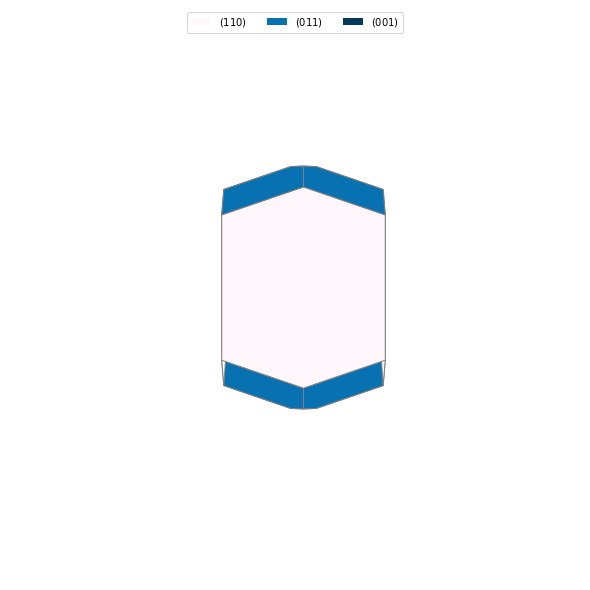

In [159]:
wulffshape = WulffShape(rutile_pmg.lattice, surfaces, energies)

# Let's get some useful information from our wulffshape object
print(
    "shape factor: %.3f, anisotropy: \
%.3f, weighted surface energy: %.3f J/m^2"
    % (
        wulffshape.shape_factor,
        wulffshape.anisotropy,
        wulffshape.weighted_surface_energy,
    )
)


# If we want to see what our Wulff shape looks like
wulffshape.

In [144]:
view(AseAtomsAdaptor().get_atoms(np0))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

## Undercoordinated less abundant atoms

In [58]:
from pymatgen.core.periodic_table import Element

composition = initial_structure.composition.get_el_amt_dict()
less_abundand_element = min(composition, key=lambda k: composition[k])

atomic_number = Element(less_abundand_element).number
less_abundand_element = atomic_number

In [59]:
def get_less_abundant_atom(initial_structure):
    
    from pymatgen.core.periodic_table import Element

    composition = initial_structure.composition.get_el_amt_dict()
    less_abundand_element = min(composition, key=lambda k: composition[k])

    atomic_number = Element(less_abundand_element).number
    less_abundand_element = atomic_number

    return atomic_number

In [25]:
def get_more_abundant_atom(initial_structure):
    
    from pymatgen.core.periodic_table import Element

    composition = initial_structure.composition.get_el_amt_dict()
    less_abundand_element = max(composition, key=lambda k: composition[k])

    atomic_number = Element(less_abundand_element).number
    less_abundand_element = atomic_number

    return atomic_number

## Surface atoms
A surface atoms has:
- lower coordination
- is linked to an undercoordinated atoms

In [6]:
# Add case where there is the same number of cations and anions

def get_surface_atoms(np0):
    
    nano = copy.deepcopy(np0)
    atomic_numbers = np.array(nano.atomic_numbers)

    #less abundant atoms
    initial_structure = rutile_pmg
    less_abundand_element = get_less_abundant_atom(initial_structure)
    less_abundand_element_index = np.where(np.array(nano.atomic_numbers) == less_abundand_element)[0]
    max_coord = np.amax(get_coordination(nano)[less_abundand_element_index])
    surface_less_abundant = np.where(get_coordination(nano)[less_abundand_element_index] < max_coord)[0]
    less_abundand_element_surface_1 = less_abundand_element_index[surface_less_abundant]


    #more aboundant atoms
    more_abundand_element = get_more_abundant_atom(initial_structure)
    more_abundand_element_index = np.where(np.array(nano.atomic_numbers) == more_abundand_element)[0]
    max_coord = np.amax(get_coordination(nano)[more_abundand_element_index])
    surface_more_abundant = np.where(get_coordination(nano)[more_abundand_element_index] < max_coord)[0]
    more_abundand_element_surface = more_abundand_element_index[surface_more_abundant]


    #less abundant atoms linked to surface more aboundant atoms
    filter_1 = atomic_numbers[np.argsort(nano.distance_matrix[more_abundand_element_surface])] == less_abundand_element
    filter_2 = np.sort(nano.distance_matrix[more_abundand_element_surface]) < 2
    distance_matrix_filter = np.argsort(nano.distance_matrix[more_abundand_element_surface]) * filter_1 * filter_2

    less_abundand_element_surface_2 = np.unique(distance_matrix_filter.flatten())[1:]

    surface_atoms = np.concatenate([less_abundand_element_surface_1,more_abundand_element_surface,less_abundand_element_surface_2])

    surface_atoms = np.unique(surface_atoms)
    
    return surface_atoms
surface_atoms = get_surface_atoms(np0)

In [131]:
len(surface_atoms)

212

In [132]:
np0.num_sites

334

In [136]:
a = Structure(np0.lattice.matrix,np.array(np0.atomic_numbers)[surface_atoms],np0.frac_coords[surface_atoms])

In [11]:
view(AseAtomsAdaptor().get_atoms(np0))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

## Improved NP0

In [140]:
test = copy.deepcopy(rutile_pmg)
test.translate_sites(np.arange(test.num_sites),[0.0,0.0,1.],frac_coords=True,to_unit_cell= False)

In [141]:
view(AseAtomsAdaptor().get_atoms(test))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [7]:
def build_np0_test(structure_init,surfaces,energies,size,rounding='closest',center=None):
# This function returns the non stoichiometric np0 with size closest to the requested one

    from pymatgen.analysis.wulff import WulffShape
    from scipy.spatial import Delaunay, ConvexHull
    
    structure = copy.deepcopy(structure_init)
    # Most/less abundant atoms
        
    laa = get_less_abundant_atom(structure_init)
    maa = get_more_abundant_atom(structure_init)
    
    #Get max coordination
    structure_tmp = copy.deepcopy(structure_init)
    structure_tmp.make_supercell(np.identity(3)*2)
    max_coord = np.max(get_coordination(structure_tmp))
    
    wulffshape = WulffShape(structure.lattice, surfaces, energies)

    atom_density = structure.num_sites/structure.volume

    ###Add rounding
    
    if center is not None:
        structure_center = copy.deepcopy(structure_init)
        structure_center.translate_sites(np.arange(structure_init.num_sites),center,
                                     frac_coords=True,to_unit_cell= False)
    else:
        structure_center = copy.deepcopy(structure_init)
        
    if type(size) == int:
        new_volume = size/atom_density
        ratio = new_volume**(1/3)/wulffshape.volume**(1/3)

        if debug == True:
            shape = ConvexHull((wulffshape.wulff_convex.points/(wulffshape.volume**(1/3)))*(new_volume**(1/3)))        
            print('NP0 size = ',shape.volume*atom_density)

        shape = Delaunay(wulffshape.wulff_convex.points*(ratio))
        
        #loop to make sure to use the smallest supercell
        num_sites = 0
        for i in range(1,10):
            structure = copy.deepcopy(structure_center)
            # Generate the supercell    
            supercell_matrix = np.zeros((3,3)) ###Make this better
            expansion = np.ceil((np.max(shape.points,axis=0)-np.min(shape.points,axis=0))/np.array(structure.lattice.abc))+i
            np.fill_diagonal(supercell_matrix,expansion)
            structure.make_supercell(supercell_matrix)

            # Center around the center of mass
            center_of_mass = np.average(structure.cart_coords,axis=0)
            structure.translate_sites(np.arange(structure.num_sites),
                                      -center_of_mass,frac_coords=False,
                                      to_unit_cell= False)

            # Generate the list of atoms to be removed
            np0_sites = []
            sites_to_remove = []
            for i,coord in enumerate(structure.cart_coords):
                if (shape.find_simplex(coord) >= 0) == False:
                    sites_to_remove.append(i)
                if (shape.find_simplex(coord) >= 0) == True:
                    np0_sites.append(i)
            sites_to_remove = np.array(sites_to_remove)        
            np0_sites = np.array(np0_sites)

            #Surface less abundant atom:
            laa_surface_sites = np0_sites[np.where(np.array(structure.atomic_numbers)[np0_sites] == laa)[0]]

            maa_surface_sites = (np.argsort(structure.distance_matrix[laa_surface_sites],axis=1)[:,1:max_coord+1])


            # Create a boolean mask indicating which elements to keep
            mask = ~np.isin(sites_to_remove, maa_surface_sites)

            # Apply the mask to the original array
            sites_to_remove_new = sites_to_remove[mask]

            structure.remove_sites(sites_to_remove_new)

            # Translate the sites back to their orginal position
            structure.translate_sites(np.arange(structure.num_sites),
                                      center_of_mass,frac_coords=False,
                                      to_unit_cell= False)

            np0 = copy.deepcopy(structure)
            if np0.num_sites > num_sites:
                num_sites = copy.deepcopy(np0.num_sites)
            else:
                return np0
    print('The supercell expansion could not be found in 10 cycles')
    return None


In [153]:
centers = [[0.,0.,0.0],[0.25,0.,0.0],[0.,0.25,0.0],[0.,0.,0.25]]
centers = [[0.,0.,0.0],[0.5,0.,0.0],[0.,0.5,0.0],[0.,0.,0.5]]
centers = [[0.,0.,0.0],[0.5,0.5,0.0],[0.,0.5,0.5],[0.5,0.,0.5]]
for center in centers:
    np0 = build_np0_test(rutile_pmg,surfaces,energies,size=100,center=center)
    view(AseAtomsAdaptor().get_atoms(np0))

In [160]:
np0 = build_np0_test(rutile_pmg,surfaces,energies,size=600)

1 0
2 773


In [146]:
surface_atoms = get_surface_atoms(np0)

In [147]:
view(AseAtomsAdaptor().get_atoms(np0))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [114]:
a = Molecule(np.array(np0.atomic_numbers)[surface_atoms],np0.cart_coords[surface_atoms])

In [127]:
a = Molecule(np.array(np0.atomic_numbers),np0.cart_coords)

In [129]:
view(AseAtomsAdaptor().get_atoms(aa['sym_mol']))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

In [128]:
aa = PointGroupAnalyzer(a).symmetrize_molecule()

In [110]:
type(aa['sym_mol'])

pymatgen.core.structure.Molecule

In [108]:
distance_matrix_sorted = np.round(np.sort(nano.distance_matrix, axis=1), 5)
first_shell = [] 
for atom in range(nano.num_sites):
    first_shell_index = np.where(distance_matrix_sorted[atom, 1:] - distance_matrix_sorted[atom, :-1] > 0.5)[0][1]
    first_shell.append(distance_matrix_sorted[atom, first_shell_index])

# Get dipole

In [ ]:
def get_dipole_moment(nano):
    molecule = Molecule(["C", "O", "H"], [[0, 0, 0], [0, 0, 1.1], [0, 1.1, 0]])

    # Get the atomic charges of the molecule (example values)
    charges = np.array([0, 0.5, -0.5])

    # Get the atomic coordinates of the molecule
    coordinates = molecule.cart_coords

    # Calculate the dipole moment
    dipole_moment = np.dot(charges, coordinates)

## Which atoms to remove?

## By coordination

In [7]:
np.max(get_coordination(np0))

6

In [15]:
n_excess_atom

44

In [9]:
from scipy.special import comb
nano = copy.deepcopy(np0)
initial_structure = copy.deepcopy(rutile_pmg)
atomic_numbers = np.array(nano.atomic_numbers)
atom_coord = get_coordination(nano)

excess_atom_index = np.where(atomic_numbers == 8)[0]

excess_atom_coord = atom_coord[excess_atom_index]
unique_coord, coord_count = np.unique(excess_atom_coord, return_counts=True)

max_coord = unique_coord[-1]
n_excess_atom = np.max(get_excess_atoms(nano, initial_structure))

if np.sum(coord_count[:-1]) < n_excess_atom:
    print('There are not enough surface atoms')

for i, n_atoms_in_coord in enumerate(coord_count):
    if n_excess_atom - n_atoms_in_coord > 0:
        n_excess_atom -= n_atoms_in_coord
    else:
        coord_combinatorial = unique_coord[i]
        break

index_combinatorial = excess_atom_index[excess_atom_coord == coord_combinatorial]

print(index_combinatorial)
n_configurations = comb(len(index_combinatorial),n_excess_atom)
print("There are %s possible configurations."%int(n_configurations))

[ 42  46  47  51  52  58  69  70  71  72  73  74  75  76  77  78  89  95
  96 100 101 105 106 107 108 109 110 115 122 123 124 125 126 131 132 137
 138 143 144 149 150 151 152 153 160 165 166 167 168 169]
There are 15890700 possible configurations.


## Indentify the outermost cations
1. they are linked to the outermost anions

In [10]:
shells = np.unique(np.round(nano.distance_matrix[0],5))
cation_sites = np.where(atomic_numbers != 8)

distance_1 = np.round(nano.distance_matrix[index_combinatorial],5)
outer_cations = np.where(distance_1 < shells[3])[1]
#np.unique(np.where(distance_1 < shells[3])[1])

In [11]:
shells[2]

1.97983

In [64]:
len(index_combinatorial)

50

In [22]:
np.arange(nano.num_sites) == index_combinatorial

/var/folders/f2/8kc7y9697m59bwltxjd42y300000gn/T/ipykernel_38954/2067127552.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  np.arange(nano.num_sites) == index_combinatorial


False

In [16]:
vview(nano)

In [12]:
nano_test = copy.deepcopy(nano)
remove_atoms = []
for i in np.arange(nano.num_sites):
    if i not in outer_cations:
        remove_atoms.append(i)
nano_test.remove_sites(remove_atoms)

### Center of mass - minimise dipole

In [121]:
nano_test = copy.deepcopy(nano)
remove_atoms = []
for i in np.arange(nano.num_sites):
    if i not in index_combinatorial:
        remove_atoms.append(i)
nano_test.remove_sites(remove_atoms)
nano_test.translate_sites(np.arange(nano_test.num_sites),-np.mean(nano_test.frac_coords,axis=0),to_unit_cell=False)
for i in range(1000):
    nano_anion = copy.deepcopy(nano_test)
    sites_random = np.random.choice(np.arange(nano_test.num_sites),6,replace=False)
    sites_to_remove = np.delete(np.arange(nano_test.num_sites), sites_random)
    #print(sites_random)
    quality_index = np.std(np.mean(nano_test.cart_coords[sites_random],axis=0))
    if quality_index < 0.01:
        print(quality_index,np.mean(nano_test.cart_coords[sites_random],axis=0))
        nano_final = copy.deepcopy(nano)
        nano_final.remove_sites(index_combinatorial[sites_to_remove])
        vview(nano_final)

9.727532978121433e-16 [ 8.14163551e-16 -1.48029737e-15  2.23446548e-16]


In [98]:
get_excess_atoms(nano,rutile_pmg)

array([44,  0])

In [101]:
nano_test.composition

Comp: O50

In [100]:
128-44

84

In [88]:
index_combinatorial[sites_to_remove]

array([ 42,  51,  71,  73,  76, 101, 109, 138, 153])

In [28]:
view(AseAtomsAdaptor().get_atoms(nano_test))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/qc/bin/p...>

### Random numbers

In [67]:
np.random.choice(np.arange(50),10,replace=False)
#len(np.unique(np.random.randint(0,2,size=(1000000,10)),axis=1))

array([46, 25, 20,  1,  6, 24,  2, 44, 15, 12])

In [ ]:
nano_test

In [29]:
coord = nano.cart_coords[index_combinatorial]
atom_types = np.array(nano.atomic_numbers)[index_combinatorial]
nano_test = 

## Quality: symmetry

In [326]:
from pymatgen.symmetry.analyzer import *

In [334]:
# Extract the atomic positions and atomic symbols from the Structure
positions = np0.cart_coords
symbols = [site.specie.symbol for site in np0]

# Create the Molecule object using the extracted information
molecule = Molecule(symbols, positions)

PointGroupAnalyzer(molecule).get_equivalent_atoms()

{'eq_sets': defaultdict(set,
             {0: {0, 33},
              1: {1, 34},
              2: {2, 35},
              3: {3, 36},
              4: {4, 37},
              5: {5, 38},
              6: {6, 39},
              7: {7},
              8: {8},
              9: {9},
              10: {10},
              11: {11},
              12: {12},
              13: {13},
              14: {14},
              16: {16, 40},
              17: {17, 41},
              18: {18, 42},
              19: {19, 43},
              20: {20, 44},
              21: {21, 45},
              22: {22, 46},
              23: {23, 47},
              24: {24, 48},
              25: {25, 73},
              26: {26, 74},
              27: {27, 75},
              28: {28, 76},
              29: {29, 77},
              30: {30, 78},
              31: {31, 79},
              32: {32, 80},
              50: {50},
              51: {51},
              52: {52},
              55: {55},
              56: {56},
       

In [335]:
molecule.get_dipole_moment()

AttributeError: 'Molecule' object has no attribute 'get_dipole_moment'

## Quality: dipole

In [303]:
charges = np.array([0, 0.5, -0.5])

# Get the atomic coordinates of the molecule
coordinates = molecule.cart_coords

# Calculate the dipole moment
dipole_moment = np.dot(charges, coordinates)

1

In [269]:
atom_coord

array([3, 6, 6, 6, 6, 5, 3, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6, 4, 5, 5, 5,
       5, 4, 5, 5, 5, 5, 4, 2, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 4, 6, 6,
       6, 6, 6, 4, 6, 6, 6, 6, 6, 5, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3,
       2, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 1, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1,
       3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 2, 1, 3, 3, 3, 3, 3, 3, 1, 2, 2, 2, 2, 1, 1, 1, 1,
       1, 1, 2, 3, 3, 3, 3, 2])

In [270]:
vview(rutile_pmg)

In [253]:
import numpy as np
from math import gcd

def get_excess_atoms(nano, initial_structure):
    """
    Calculate the number of excess atoms to be removed from a nanoparticle structure compared to an initial bulk structure.

    Args:
        nano (pymatgen.core.structure.Structure): The nanoparticle structure.
        initial_structure (pymatgen.core.structure.Structure): The initial bulk structure.

    Returns:
        numpy.ndarray: An array containing the number of atoms to be removed.
    """
    
    import numpy as np
    from math import gcd

    # Get the atomic numbers of the nanoparticle structure
    atomic_numbers_np = np.array(nano.atomic_numbers)

    # Get the unique atom types present in the initial structure
    unique_atom_types = np.unique(initial_structure.atomic_numbers)

    # Calculate the composition of the nanoparticle structure and initial structure
    nano_composition = []
    initial_composition = []

    for atom_type in unique_atom_types:
        # Count the number of atoms of each type in the nanoparticle structure
        nano_count = len(np.where(atomic_numbers_np == atom_type)[0])
        nano_composition.append(nano_count)

        # Count the number of atoms of each type in the initial structure
        initial_count = len(np.where(initial_structure.atomic_numbers == atom_type)[0])
        initial_composition.append(initial_count)

    nano_composition = np.array(nano_composition)
    initial_composition = np.array(initial_composition)

    # Round the values to the nearest integer
    initial_composition = np.round(initial_composition)

    # Divide all elements by their greatest common divisor (GCD)
    initial_composition_gcd = int(np.abs(gcd(*initial_composition)))
    initial_composition //= initial_composition_gcd

    t = np.argmin((nano_composition / np.amin(nano_composition)) / initial_composition)
    ideal_cl = nano_composition[t] // initial_composition[t] * initial_composition

    excess = nano_composition - ideal_cl
    ideal_cl = nano_composition[t] // initial_composition[t] * initial_composition
    
    return nano_composition - ideal_cl
        
get_excess_atoms(np0, rutile_pmg)

array([22,  0])

In [ ]:
t= np.argmin((stoich_cl/np.amin(stoich_cl))/unit_formula_unit)
ideal_cl = stoich_cl[t]//unit_formula_unit[t] * unit_formula_unit
atoms.excess = stoich_cl - ideal_cl

In [250]:
np0.composition.get_el_amt_dict()

defaultdict(float, {'Ti': 54.0, 'O': 130.0})

In [203]:
debug = True
def build_np0(structure,surfaces,energies,size,rounding='closest'):
# This function returns the non stoichiometric np0 with size closest to the requested one

    from pymatgen.analysis.wulff import WulffShape
    from scipy.spatial import Delaunay, ConvexHull

    wulffshape = WulffShape(structure.lattice, surfaces, energies)

    atom_density = structure.num_sites/structure.volume
    wulffshape.volume

    ###Add rounding

    if type(size) == int:
        new_volume = size/atom_density
        ratio = new_volume**(1/3)/wulffshape.volume**(1/3)

        if debug == True:
            shape = ConvexHull((wulffshape.wulff_convex.points/(wulffshape.volume**(1/3)))*(new_volume**(1/3)))        
            print('NP0 size = ',shape.volume*atom_density)

        shape = Delaunay(wulffshape.wulff_convex.points*(ratio))
        sites_to_remove = []
        
        # Generate the supercell
        supercell_matrix = np.identity(3)*10 ###Make this better
        structure.make_supercell(supercell_matrix)
        #
        # Center around the center of mass
        center_of_mass = np.average(structure.cart_coords,axis=0)
        structure.translate_sites(np.arange(structure.num_sites),
                                  -center_of_mass,frac_coords=False,
                                  to_unit_cell= False)
        
        # Generate the list of atoms to be removed
        for i,coord in enumerate(structure.cart_coords):
            if (shape.find_simplex(coord) >= 0) == False:
                sites_to_remove.append(i)
        
        structure.remove_sites(sites_to_remove)
        
        # Translate the sites back to their orginal position
        structure.translate_sites(np.arange(structure.num_sites),
                                  center_of_mass,frac_coords=False,
                                  to_unit_cell= False)
        view(AseAtomsAdaptor().get_atoms(structure))
        np0 = structure
        
        return np0
structure = copy.deepcopy(rutile_pmg)
np0 = build_np0(structure,surfaces,energies,size=500)
np0.num_sites

NP0 size =  499.99999999999966


546

In [76]:
view(AseAtomsAdaptor().get_atoms(structure))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [7]:
def remove_excess_atoms(np0,nano_remove_array):
   
    # Read the 
    from pymatgen.core.periodic_table import Element

    atom_symbols = list(np0.composition.reduced_composition.as_dict().keys())
    atomic_number = np.array([Element(atom_symbol).number for atom_symbol in atom_symbols])

    atoms_type_site = []
    for atom in atomic_number:
        atoms_type_site.append(np.where(np0.atomic_numbers == atom)[0])    
        coord_vector = get_coordination(np0)

    for i,atoms in enumerate(nano_remove_array):
        if atoms > 0:     
            coord_sorted = np.sort(coord_vector[atoms_type_site[i]])
            unique_coord, count_unique = np.unique(coord_sorted, return_counts=True)
            # This is the beginning of the combinatorial analysis
            '''if count_unique[0] < atoms:
                index = atoms
                for j in count_unique:
                    if j < index:
                        atoms_to_remove = np.argsort(coord_vector[atoms_type_site[i]])[0:count_unique]
            elif count_unique[0] > atoms:'''
                # remove the top ones in the array
            atoms_to_remove = np.argsort(coord_vector[atoms_type_site[i]])[0:atoms]
                # do all the combinations
                #import itertools
                #X = np.array(list(itertools.product([0, 1], repeat=18)))
                #np.where(np.sum(X,axis=1) == 2)
                # This easily becomes too large to explore
                
                # add symmetry analysis
    np0.remove_sites(atoms_to_remove)

    return np0

In [230]:
def get_coordination(nano):
    """
    Function that calculates the coordination of the crystal.

    Args:
        nano (pymatgen.core.structure.Structure): The pymatgen Structure object.
    Returns:
        numpy.ndarray: A numpy array containing the coordination number for each site.
    """

    # Position of atoms types in the structure
    atoms_type_site = []
    for atom in np.unique(nano.atomic_numbers):
        atoms_type_site.append(np.where(nano.atomic_numbers == atom)[0])
    atomic_numbers = nano.atomic_numbers

    distance_matrix_sorted = np.round(np.sort(nano.distance_matrix, axis=1), 5)

    first_shell = []  # Defined as a jump of 0.5 Angstrom
    second_shell = []
    for atom in range(nano.num_sites):
        first_shell_index = np.where(distance_matrix_sorted[atom, 1:] - distance_matrix_sorted[atom, :-1] > 0.5)[0][1]
        first_shell.append(distance_matrix_sorted[atom, first_shell_index])

    # second_shell_index = np.where(distance_matrix_sorted[atom, 1:] - distance_matrix_sorted[atom, :-1] > 0.5)[0]
    # second_shell.append(distance_matrix_sorted[atom, second_shell_index])

    first_shell_index = np.array(first_shell_index)

    coord_vector = np.zeros(nano.num_sites, dtype=int)

    for i in range(nano.num_sites):
        coord_vector[i] = np.sum(distance_matrix_sorted[i, 1:10] <= first_shell[i])

    return coord_vector
get_coordination(np0)

array([3, 3, 3, 3, 3, 3, 2, 3, 5, 5, 5, 5, 5, 5, 5, 3, 5, 6, 6, 6, 6, 6,
       6, 6, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 2, 5, 6, 6, 6,
       6, 6, 6, 6, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6, 6,
       6, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 6, 6, 6, 6, 6, 6,
       6, 3, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3, 3, 5, 6, 6, 6, 6, 6, 6,
       3, 4, 5, 5, 5, 5, 5, 5, 3, 5, 6, 6, 6, 6, 6, 6, 3, 5, 6, 6, 6, 6,
       6, 6, 6, 6, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 5, 5, 5, 5, 5, 5, 4,
       5, 5, 5, 5, 5, 5, 3, 4, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6,
       6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4,
       4, 4, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3,
       3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3,
       3, 3, 2, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3,

In [100]:
vview(np0)

In [60]:
from pymatgen.analysis.local_env import VoronoiNN

def get_coordination(nano):
    """
    Calculate the coordination of atoms in a pymatgen Structure using their atomic radius.

    Args:
        nano (pymatgen.core.structure.Structure): The pymatgen Structure object.

    Returns:
        list: A list of coordination numbers for each site.
    """
    voronoi = VoronoiNN()
    coordination_numbers = [len(voronoi.get_nn_info(nano, i)) for i in range(len(nano))]
    return coordination_numbers
get_coordination(np0)

[13,
 10,
 10,
 13,
 13,
 10,
 10,
 13,
 9,
 10,
 10,
 10,
 10,
 10,
 15,
 9,
 9,
 12,
 15,
 9,
 9,
 12,
 8,
 8,
 8,
 8,
 8,
 12,
 11,
 11,
 7,
 7,
 15,
 11,
 11,
 7,
 11,
 27,
 8,
 14,
 14,
 7,
 21,
 21,
 21,
 21,
 30,
 16,
 18,
 12,
 12,
 20,
 11,
 18,
 12,
 18,
 20,
 15,
 17,
 17,
 17,
 12,
 14,
 18,
 18,
 18,
 18,
 12,
 12,
 13,
 12,
 12,
 15,
 11,
 13,
 13,
 13,
 15,
 12,
 13,
 13,
 13,
 11,
 13,
 18,
 18,
 18,
 18,
 13,
 11,
 16,
 11,
 15,
 12,
 13,
 13,
 13,
 11,
 13,
 18,
 18,
 18,
 18,
 13,
 16,
 16,
 16,
 15]

In [82]:
np.where(np.round(np.sort(np0.distance_matrix[0,1:])- np.sort(np0.distance_matrix[0,:-1]),5) > 0.5)[0][1]

array([  0,   3,   4,  11,  19, 101])

In [84]:
np.sort(np0.distance_matrix,axis=1)

array([[ 0.        ,  1.94746733,  1.94746733, ..., 13.85193741,
        14.2363843 , 14.43292375],
       [ 0.        ,  1.94746733,  1.94746733, ..., 11.17632856,
        11.75655085, 11.88879464],
       [ 0.        ,  1.94746733,  1.94746733, ..., 10.36485649,
        10.36485649, 10.92331452],
       ...,
       [ 0.        ,  1.94746733,  1.94746733, ...,  9.99612425,
        10.12018523, 10.90189282],
       [ 0.        ,  1.94746733,  1.94746733, ..., 11.17632856,
        11.69057227, 11.77092312],
       [ 0.        ,  1.94746733,  1.97982828, ..., 13.85193741,
        14.07127144, 14.44463329]])

In [4]:
lattice = Lattice.cubic(3.508)
Ni = Structure(
    lattice,
    ["Ni", "Ni", "Ni", "Ni"],
    [[0, 0, 0], [0, 0.5, 0], [0.5, 0, 0], [0, 0, 0.5]],
)
structure = Ni

In [3]:
slabgen = SlabGenerator(Ni, (1, 1, 1), 10, 10)

all_slabs = slabgen.get_slabs()

In [7]:
surface_energies_Ni = surface_energies_Ni = {
    (3, 2, 0): 2.3869,
    (1, 1, 0): 2.2862,
    (3, 1, 0): 2.3964,
    (2, 1, 0): 2.3969,
    (3, 3, 2): 2.0944,
    (1, 0, 0): 2.2084,
    (2, 1, 1): 2.2353,
    (3, 2, 2): 2.1242,
    (3, 2, 1): 2.3183,
    (2, 2, 1): 2.1732,
    (3, 3, 1): 2.2288,
    (3, 1, 1): 2.3039,
    (1, 1, 1): 1.9235,
}
'''surface_energies_Ni = surface_energies_Ni = {
    (1, 0, 0): 2.2084,
}'''
miller_list = surface_energies_Ni.keys()
e_surf_list = surface_energies_Ni.values()

# We can now construct a Wulff shape with an accuracy up to a max Miller index of 3
wulffshape = WulffShape(Ni.lattice, miller_list, e_surf_list)

# Let's get some useful information from our wulffshape object
print(
    "shape factor: %.3f, anisotropy: \
%.3f, weighted surface energy: %.3f J/m^2"
    % (
        wulffshape.shape_factor,
        wulffshape.anisotropy,
        wulffshape.weighted_surface_energy,
    )
)


# If we want to see what our Wulff shape looks like
#wulffshape.show()

shape factor: 5.178, anisotropy: 0.070, weighted surface energy: 2.035 J/m^2


## Make sized cluster

In [10]:
import numpy as np

lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])
structure = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
structure = SpacegroupAnalyzer(structure).get_conventional_standard_structure()

wulffshape = WulffShape(Ni.lattice, miller_list, e_surf_list)
atom_density = structure.num_sites/structure.volume
wulffshape.volume
#wulffshape.wulff_convex.points
wulff_atoms_0 = wulffshape.volume * atom_density
wulff_atoms_1 = 100

new_volume = 100/atom_density
volume_ratio = new_volume/wulffshape.volume
ratio = volume_ratio**1/3

shape = ConvexHull((wulffshape.wulff_convex.points/(wulffshape.volume**(1/3)))*(new_volume**(1/3)))
shape.volume*atom_density

100.00000000000007

# Make wulff-shaped NP

In [9]:
from scipy.spatial import Delaunay, ConvexHull
import numpy as np
poly = np.array([[0,0.5,0],[1.8,1,1],[2,2,2.1],[3,3.4,3]])
poly= np.array(wulffshape.get_line_in_facet(wulffshape.facets[1]))
test = []
for i in range(1000):
    point = np.array([i,i,i])
    test.append(Delaunay(wulffshape.wulff_convex.points).find_simplex(point) >= 0)

In [105]:
lattice =  np.array(  [[0.000000000000E+00 ,  0.210850000000E+01 ,  0.210850000000E+01],
   [0.210850000000E+01 ,  0.000000000000E+00  , 0.210850000000E+01],
   [0.210850000000E+01 ,  0.210850000000E+01 ,  0.000000000000E+00]])
structure = Structure(lattice,['Mg','O'],[[0.,0.,0.],[0.5,0.5,0.5]])
structure = SpacegroupAnalyzer(structure).get_conventional_standard_structure()

supercell_matrix = np.identity(3)*10
structure.make_supercell(supercell_matrix)
center_of_mass = np.average(structure.cart_coords,axis=0)
structure.translate_sites(np.arange(structure.num_sites),-center_of_mass,frac_coords=False,to_unit_cell= False)
structure.num_sites

8000

In [106]:
shape = Delaunay(wulffshape.wulff_convex.points*(new_volume**(1/3)/wulffshape.volume**(1/3)))
#shape = Delaunay(wulffshape.wulff_convex.points*(wulffshape.volume**(1/3))*(new_volume**(1/3))
sites_to_remove = []
for i,coord in enumerate(structure.cart_coords):
    if (shape.find_simplex(coord) >= 0) == False:
        sites_to_remove.append(i)
structure.remove_sites(sites_to_remove)
structure.num_sites

80

In [108]:
view(AseAtomsAdaptor().get_atoms(structure))

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/test_env...>

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [119]:
from pymatgen.analysis.local_env import BrunnerNN_real, CrystalNN

In [125]:
CrystalNN(structure).get_nn_shell_info(structure,0,2)

[{'site': PeriodicSite: Mg (-5.2713, -1.0543, 1.0542) [-0.1250, -0.0250, 0.0250],
  'image': (0, 0, 0),
  'weight': 1.0000291802820345,
  'site_index': 30},
 {'site': PeriodicSite: Mg (-3.1628, -1.0543, 3.1627) [-0.0750, -0.0250, 0.0750],
  'image': (0, 0, 0),
  'weight': 1.000072950508118,
  'site_index': 11},
 {'site': PeriodicSite: Mg (-3.1628, -1.0543, -1.0543) [-0.0750, -0.0250, -0.0250],
  'image': (0, 0, 0),
  'weight': 1.148628452586877,
  'site_index': 10},
 {'site': PeriodicSite: Mg (-3.1628, 1.0542, 1.0542) [-0.0750, 0.0250, 0.0250],
  'image': (0, 0, 0),
  'weight': 1.0,
  'site_index': 2},
 {'site': PeriodicSite: Mg (-1.0543, -1.0543, 1.0542) [-0.0250, -0.0250, 0.0250],
  'image': (0, 0, 0),
  'weight': 2.0,
  'site_index': 33},
 {'site': PeriodicSite: Mg (1.0542, -3.1628, 1.0542) [0.0250, -0.0750, 0.0250],
  'image': (0, 0, 0),
  'weight': 1.0,
  'site_index': 4},
 {'site': PeriodicSite: Mg (-1.0543, -3.1628, 3.1627) [-0.0250, -0.0750, 0.0750],
  'image': (0, 0, 0),
  'we

In [128]:
np.unique(np.round(structure.distance_matrix,5))

array([ 0.     ,  2.1085 ,  2.98187,  3.65203,  4.217  ,  4.71475,
        5.16475,  5.96374,  6.3255 ,  6.66766,  6.9931 ,  7.30406,
        7.6023 ,  7.88928,  8.434  ,  8.69357,  8.94561,  9.19074,
        9.4295 ,  9.66236, 10.5425 , 10.75128, 10.95609])

In [15]:
from mendeleev import *

In [17]:
Mg.atomic_number

12